In [1]:
import seaborn as sbn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model as linear_model
from sklearn.pipeline import make_pipeline

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
import sklearn.linear_model as linear_model

In [3]:
# import os
# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

Params

In [4]:
path_to_train_csv = '/media/admiral/SSD/NN market/train.csv' #_small

In [5]:
def load_data():
    # Load 50 rows to understand types of cols
    train_csv = pd.read_csv(path_to_train_csv, nrows=50) 
    # Finding float cols
    float_cols = [c for c in train_csv if train_csv[c].dtype == "float64"]
    # Float64 to Float16
    types = {c: 'float16' for c in float_cols}
    # Loading all rows
    train_csv = pd.read_csv(path_to_train_csv, engine='c', dtype=types)
    
    
    
    
    return train_csv

In [6]:
train_csv = load_data()
train_csv.head(5)

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009918,0.014076,0.008774,0.001390,0.006271,1,-1.873047,-2.191406,...,NaN,1.167969,8.312500,1.782227,14.015625,2.652344,12.601562,2.300781,11.445312,0
1,0,16.671875,-0.002829,-0.003227,-0.007320,-0.011116,-0.009789,-1,-1.349609,-1.705078,...,NaN,-1.178711,1.777344,-0.915527,2.832031,-1.416992,2.296875,-1.304688,1.898438,1
2,0,0.000000,0.025131,0.027603,0.033417,0.034393,0.023972,-1,0.812988,-0.256104,...,NaN,6.117188,9.664062,5.542969,11.671875,7.281250,10.062500,6.636719,9.429688,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003201,-1,1.174805,0.344727,...,NaN,2.837891,0.499268,3.033203,1.513672,4.398438,1.265625,3.855469,1.013672,3
4,0,0.138550,0.001252,0.002165,-0.001216,-0.006218,-0.002604,1,-3.171875,-3.093750,...,NaN,0.344971,4.101562,0.614258,6.625000,0.800293,5.234375,0.362549,3.925781,4


Sampling some part of data

In [7]:
def preprocess_data(df):
    train_sample = df.sample(n=200_000, axis=0)
    train_sample = train_sample.dropna()
    
    #Scale features, weight ans respones to [0, 1]
    #cols_no_scale = ['date', 'ts_id']
    temp_date = train_sample['date']
    temp_id = train_sample['ts_id']
    
    train_sample=(train_sample-train_sample.min())/(train_sample.max()-train_sample.min())
    
    train_sample['date'] = temp_date
    train_sample['ts_id'] = temp_id
    
    return train_sample

In [8]:
train_sample = preprocess_data(train_csv)
train_sample# = train_csv

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
187904,29,0.013610,0.537135,0.524695,0.589776,0.579929,0.515139,1.0,0.046213,0.021993,...,0.177710,0.081354,0.034478,0.085066,0.202782,0.126664,0.088387,0.104079,0.054971,187904
261552,41,0.000000,0.537402,0.521753,0.579775,0.580448,0.520256,0.0,0.011595,0.006586,...,0.206053,0.069710,0.042352,0.070259,0.252355,0.107319,0.111529,0.088211,0.069492,261552
2336391,490,0.012353,0.528829,0.518669,0.585148,0.588001,0.529574,0.0,0.032887,0.026661,...,0.343041,0.084672,0.055359,0.094755,0.384702,0.140283,0.173528,0.120541,0.114023,2336391
1890422,402,0.000000,0.557629,0.542004,0.573993,0.564779,0.520124,0.0,0.065171,0.033392,...,0.217642,0.122429,0.037312,0.144899,0.239681,0.188274,0.094456,0.158885,0.059727,1890422
421568,65,0.008640,0.536414,0.523108,0.578173,0.576010,0.522760,1.0,0.039435,0.024598,...,0.252834,0.096782,0.058040,0.095699,0.317183,0.139212,0.135137,0.120301,0.089682,421568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718902,139,0.246417,0.535375,0.521726,0.579393,0.573968,0.513690,0.0,0.054398,0.053269,...,0.246759,0.055193,0.036855,0.064247,0.278507,0.085902,0.105815,0.064615,0.059489,718902
90221,14,0.000000,0.531177,0.518140,0.575920,0.571178,0.510928,1.0,0.034180,0.019480,...,0.190513,0.047857,0.028452,0.060985,0.224615,0.087531,0.091255,0.061048,0.049816,90221
994049,207,0.010711,0.496240,0.503116,0.541618,0.483403,0.378453,0.0,0.070344,0.023950,...,0.148749,0.204471,0.032958,0.253598,0.169732,0.302542,0.076294,0.265136,0.051872,994049
1951905,416,0.000970,0.516373,0.505361,0.563093,0.563245,0.498588,1.0,0.072387,0.046244,...,0.368778,0.160418,0.051609,0.262040,0.420667,0.303566,0.186600,0.220733,0.093372,1951905


In [ ]:
train_sample.to_csv('train_small.csv')

In [ ]:
par = ["feature_%d" % i for i in range(130)]
par.append('resp')
corr = train_sample[par].corr().replace(1, 0)

In [ ]:
print(corr['resp'].max(), corr['resp'].min())

In [ ]:
print(corr['resp'].index[corr['resp'].argmax()], corr['resp'].index[corr['resp'].argmin()])

In [ ]:
s1 = train_sample['feature_33'] + train_sample['feature_31']
train_sample['resp'].corr(s1)

In [ ]:
corr.drop(index = 'feature_31', inplace=True)

In [ ]:
train_sample['resp']

In [ ]:
train_sample['feature_128']

GENERATOR
==

In [17]:
data_corrs = []
for feature in ["feature_%d" % i for i in range(130)]:
    data_corrs.append(train_sample['date'].corr(train_sample[feature]))

In [18]:
data_corrs = np.array(data_corrs)
data_corrs.argsort()

array([ 45,  43,  95, 107, 119, 114,  90, 102,  55,  44,  57,  58, 116,
        92,  59, 117, 104,  56,  93,  47,  46, 118, 120,  50, 105,  53,
        67,  68, 126, 128, 124,   9, 122,  64, 115,  54,  94,  15, 121,
         1,  69,  35, 113,  29,  91,  89, 129, 123,  42, 106, 127,  33,
       101, 125,  13,  61,  60,  36,  31, 108,  65,  66, 103,  30,  52,
        11,  27,   7,  19,  34,  84,  25,  48,  96,  23,  32,  73,  70,
        28,   6,  76,  39,  40,   5,  63,  81,  79,  62,  21,  17,  80,
        82,   8,  75,   4,  78,   3,  72,  98,  86,  74, 110,  26,  20,
        37,  24,  77,  38,  12,  18,  22,  87,   0,  14,  83,  88,  85,
        16,  10,  51,  99,  49, 111, 100,   2,  97,  41,  71, 112, 109])

<AxesSubplot:xlabel='date', ylabel='feature_43'>

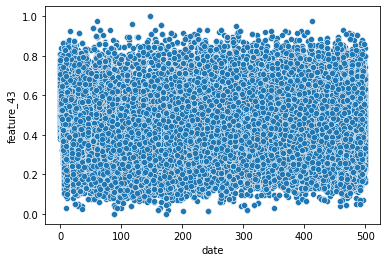

In [21]:
sbn.scatterplot(data=train_sample, x='date', y='feature_43')